# Visualizing Processed Labels
This notebook takes analyzes processed labels to ensure consistency.

In [1]:
!pip install seaborn -q
!pip install altair -q

In [2]:
from datetime import timedelta
from shapely.geometry import Point
from pyproj import Transformer
from tqdm.notebook import tqdm
import altair as alt
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

import sys
sys.path.append("..")

from src.dataset_config import labeled_datasets
from utils import get_dvc_dir

# Read in data

In [3]:
test_dir = get_dvc_dir("test")
africa = geopandas.read_file(test_dir / "afr_g2014_2013_0")

In [155]:
get_dvc_dir("processed")
df = pd.concat([pd.read_csv(d.labels_path) for d in labeled_datasets])

In [156]:
df[df['source'] == 'loc_all_2']

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country,file_name
0,-179.750000,71.452381,2017-03-28,2018-03-28,loc_all_2,0.00,1,training,global,0_2017-03-28_2018-03-28
1,-175.047619,-19.750000,2017-03-28,2018-03-28,loc_all_2,0.00,1,training,global,1_2017-03-28_2018-03-28
2,-172.250000,-13.547619,2017-03-28,2018-03-28,loc_all_2,0.00,1,training,global,2_2017-03-28_2018-03-28
3,-164.750000,62.452381,2017-03-28,2018-03-28,loc_all_2,0.00,1,validation,global,3_2017-03-28_2018-03-28
4,-163.250000,62.452381,2017-03-28,2018-03-28,loc_all_2,0.00,1,training,global,4_2017-03-28_2018-03-28
...,...,...,...,...,...,...,...,...,...,...
35861,178.750000,70.952381,2017-03-28,2018-03-28,loc_all_2,0.00,1,training,global,35861_2017-03-28_2018-03-28
35862,178.952381,-16.750000,2017-03-28,2018-03-28,loc_all_2,0.00,1,training,global,35862_2017-03-28_2018-03-28
35863,179.250000,-16.547619,2017-03-28,2018-03-28,loc_all_2,0.00,1,training,global,35863_2017-03-28_2018-03-28
35864,179.550595,-16.348214,2017-03-28,2018-03-28,loc_all_2,0.49,1,training,global,35864_2017-03-28_2018-03-28


# Checking Label Distributions

In [126]:
df["geometry"] = [Point(xy) for xy in zip(df["lon"], df["lat"])]
df.head()

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,country,geometry
0,-179.750000,71.452381,2017-04-02,2018-03-28,loc_all_2,0.0,1,global,POINT (-179.75 71.45238095000001)
1,-175.047619,-19.750000,2017-04-02,2018-03-28,loc_all_2,0.0,1,global,POINT (-175.047619 -19.75)
2,-172.250000,-13.547619,2017-04-02,2018-03-28,loc_all_2,0.0,1,global,POINT (-172.25 -13.54761905)
3,-164.750000,62.452381,2017-04-02,2018-03-28,loc_all_2,0.0,1,global,POINT (-164.75 62.45238095)
4,-163.250000,62.452381,2017-04-02,2018-03-28,loc_all_2,0.0,1,global,POINT (-163.25 62.45238095)


In [127]:
def plot_country_specific_labels(df, hue):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.countplot(ax=ax, data=df, x='country', hue=hue)
    sns.despine()
    ax.set_title(f"Country Specific Labels Distribution by {hue}");

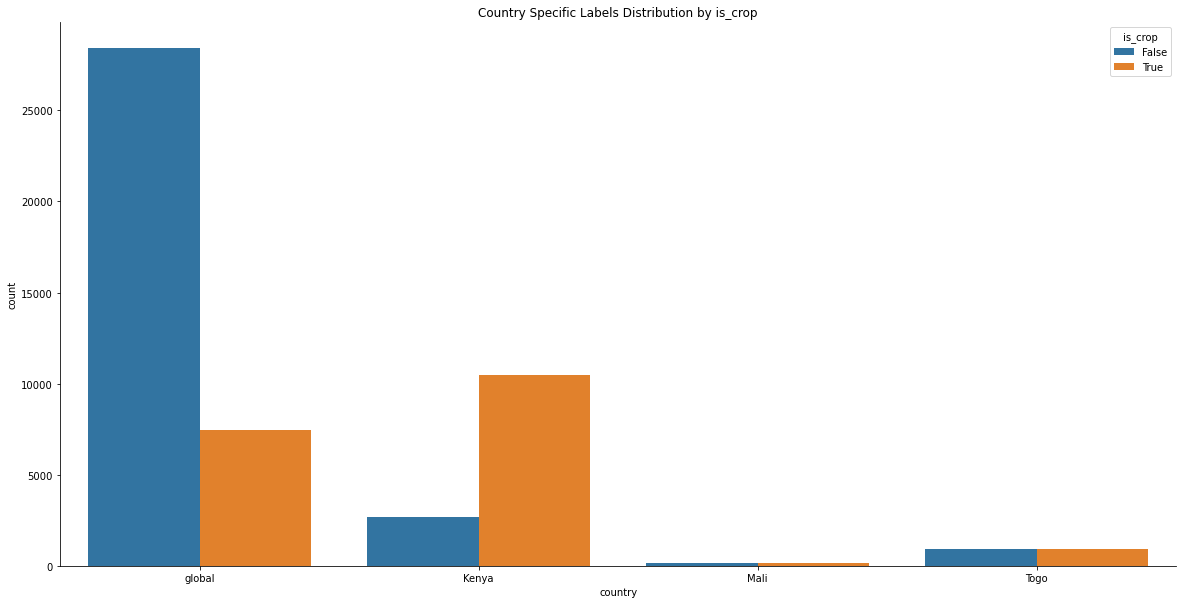

In [128]:
df["is_crop"] = df["crop_probability"] > 0.5 
plot_country_specific_labels(df, "is_crop")

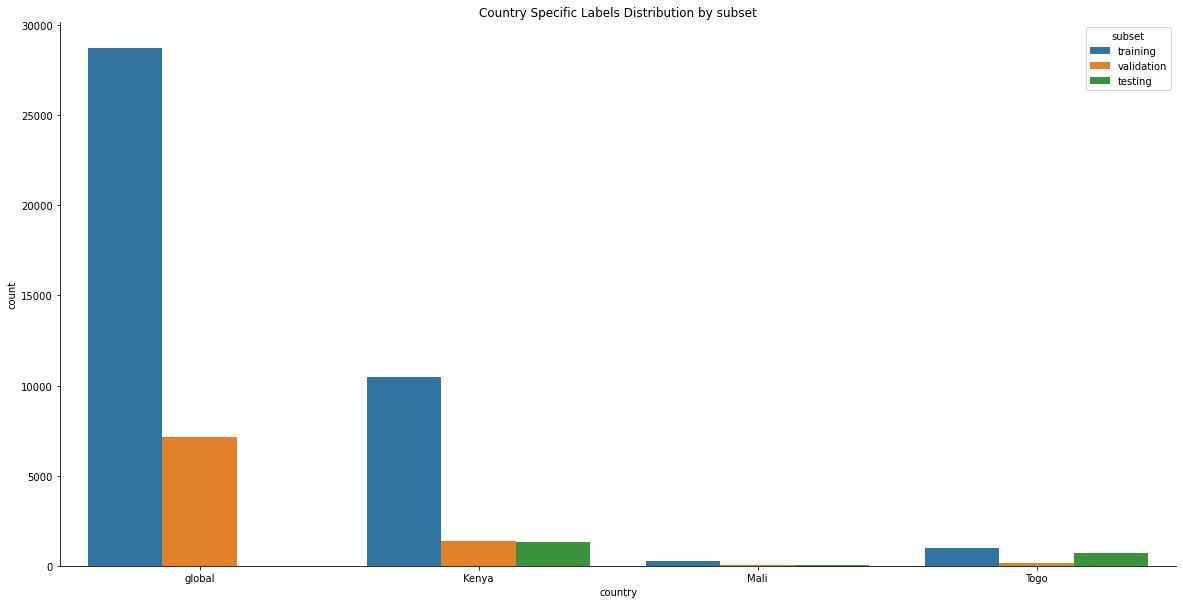

In [150]:
plot_country_specific_labels(df, "subset")

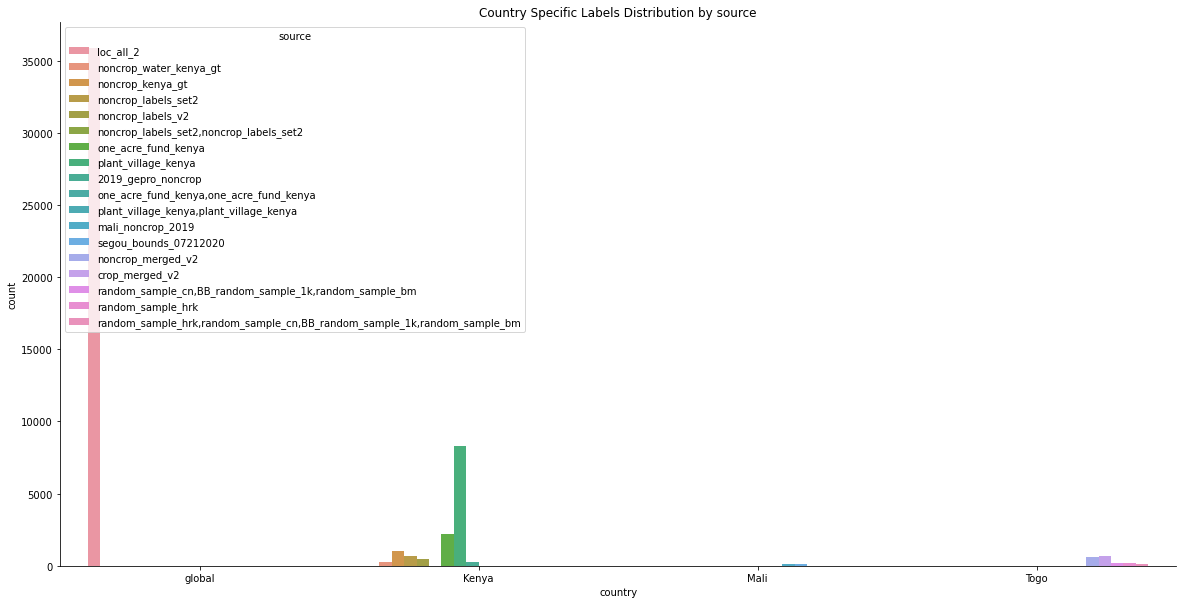

In [129]:
plot_country_specific_labels(df, "source")

In [130]:
df_non_global = geopandas.GeoDataFrame(df[df['country'] != "global"])

def within_country(point: Point, country: str, pbar):
    pbar.update(1)
    return point.within(africa[africa["ADM0_NAME"] == country]["geometry"].iloc[0])


with tqdm(total=len(df_non_global)) as pbar:
    df_non_global["point_within_country"] = np.vectorize(within_country)(df_non_global["geometry"], df_non_global["country"], pbar)

  0%|          | 0/15297 [00:00<?, ?it/s]

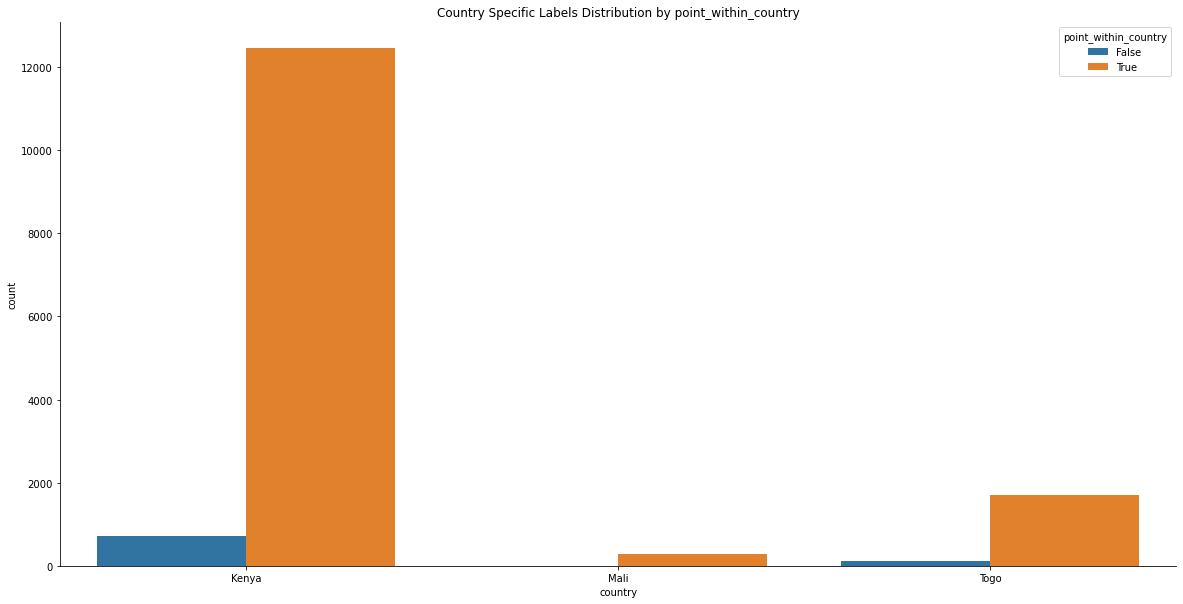

In [131]:
plot_country_specific_labels(df_non_global, "point_within_country")

In [132]:
df_non_global['country_and_source'] = df_non_global['country'] + "/" + df_non_global['source']

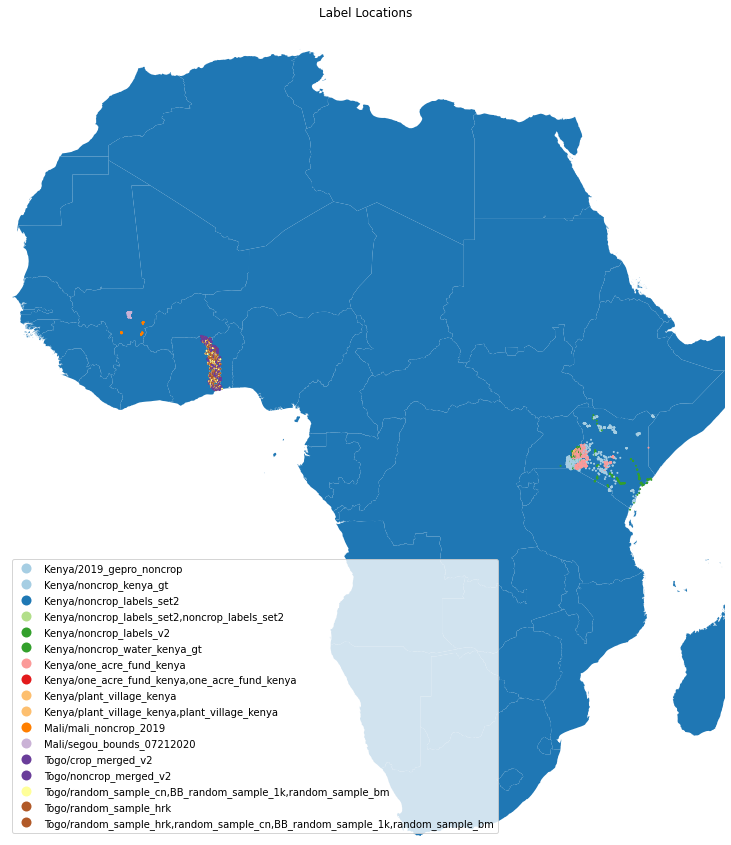

In [134]:
ax=africa.plot(figsize=(15,15))
ax.set_xlim(-18, 48)
ax.set_ylim(-35, 40)
ax.set_title("Label Locations")
ax.axis('off')
df_non_global.plot(
    ax=ax, 
    marker='o', 
    column='country_and_source', 
    categorical=True,
    markersize=1,
    cmap='Paired',
    legend=True,
    legend_kwds={'loc': 'lower left'});

# Checking Export Date Ranges

In [136]:
date_ranges = df[['start_date', 'end_date', 'source', 'country']].drop_duplicates()

In [137]:
alt.Chart(date_ranges).mark_bar().encode(
    x='start_date',
    x2='end_date',
    y='source'
)

alt.Chart(...)

# Investigating Kenya PV Date Ranges

In [138]:
pv_kenya_dates = df[df['source'] == 'plant_village_kenya'][['planting_d', 'harvest_da']]
pv_kenya_dates['planting_d'] = pd.to_datetime(pv_kenya_dates['planting_d'])
pv_kenya_dates['harvest_da'] = pd.to_datetime(pv_kenya_dates['harvest_da'])
pv_kenya_dates['between_days'] = (pv_kenya_dates['harvest_da'] - pv_kenya_dates['planting_d']).dt.days
pv_kenya_dates['valid'] = (0 < pv_kenya_dates['between_days']) & (pv_kenya_dates['between_days'] < 365)
pv_kenya_dates['planting_d_str'] = pv_kenya_dates['planting_d'].dt.strftime("%Y-%m-%d")
pv_kenya_dates['harvest_da_str'] = pv_kenya_dates['harvest_da'].dt.strftime("%Y-%m-%d")
pv_kenya_dates['range'] = pv_kenya_dates['planting_d_str'] + "_" + pv_kenya_dates['harvest_da_str']
pv_kenya_dates.head()

KeyError: "None of [Index(['planting_d', 'harvest_da'], dtype='object')] are in the [columns]"

NameError: name 'pv_kenya_dates' is not defined

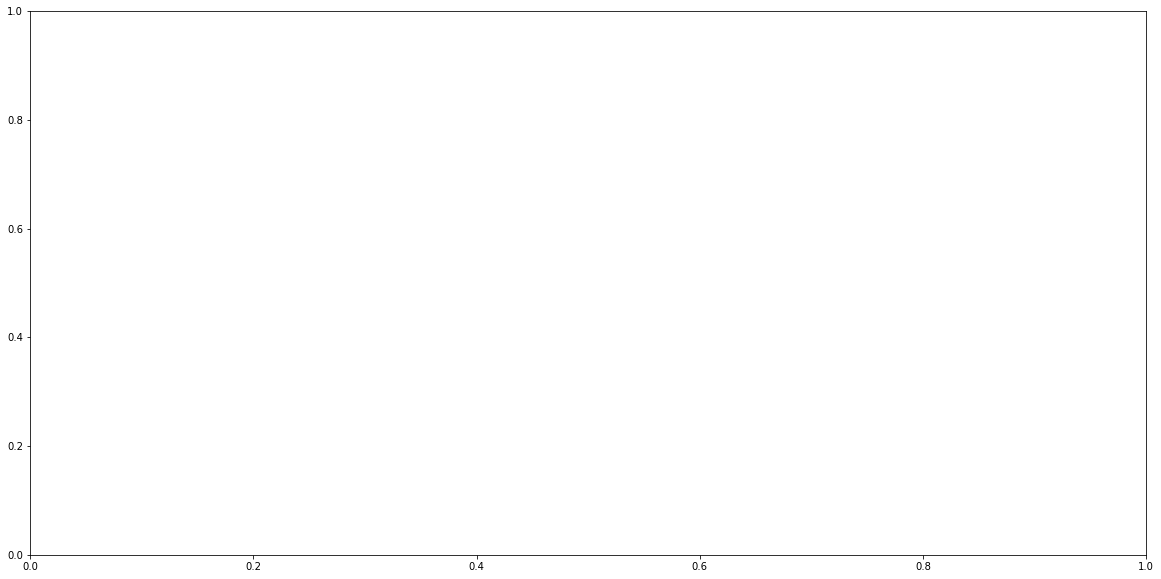

In [139]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=pv_kenya_dates, x='between_days', ax=ax, hue='valid', palette=["red", "green"], binwidth=20)
sns.despine()
ax.set_title("Valid (?) days between planting date and harvest date for Kenya PV dataset");

In [60]:
year = pd.to_timedelta(timedelta(days=365))

# if 0 > between days > -365, increase harvest_da year
mask = (pv_kenya_dates['between_days'] < 0) & (pv_kenya_dates['between_days'] > -365)
pv_kenya_dates.loc[mask, 'harvest_da'] += year

# if 365 < between days > (2*365), decrease harvest_da year
mask = (pv_kenya_dates['between_days'] > 365) & (pv_kenya_dates['between_days'] < (365*2))
pv_kenya_dates.loc[mask, 'harvest_da'] -= year

# if 365 < between days > (2*365), decrease harvest_da year
mask = (pv_kenya_dates['between_days'] > (365*2)) & (pv_kenya_dates['between_days'] < (365*3))
pv_kenya_dates.loc[mask, 'harvest_da'] -= (2*year)

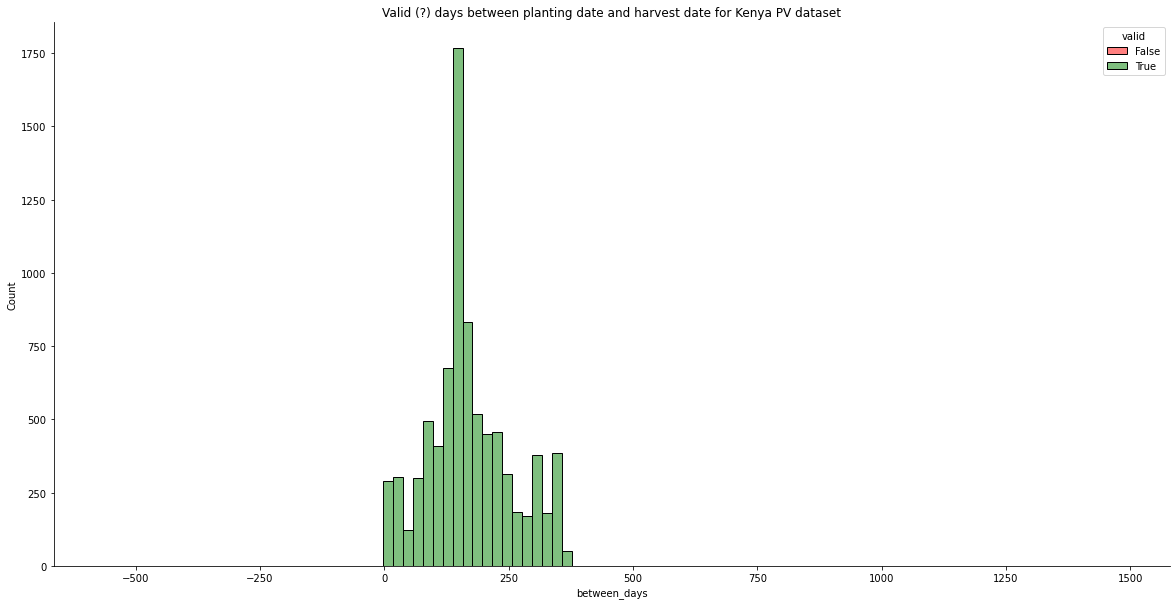

In [61]:
pv_kenya_dates['between_days'] = (pv_kenya_dates['harvest_da'] - pv_kenya_dates['planting_d']).dt.days
pv_kenya_dates['valid'] = (0 < pv_kenya_dates['between_days']) & (pv_kenya_dates['between_days'] <= 365)

fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=pv_kenya_dates, x='between_days', ax=ax, hue='valid', palette=["red", "green"], binwidth=20)
sns.despine()
ax.set_title("Valid (?) days between planting date and harvest date for Kenya PV dataset");

In [52]:
pv_kenya_dates[pv_kenya_dates['valid'] == False]

,planting_d,harvest_da,between_days,valid,planting_d_str,harvest_da_str,range
4946,2019-07-28,2018-01-11,-563,False,2019-07-28,2018-01-11,2019-07-28_2018-01-11
10705,2016-07-14,2020-01-01,1266,False,2016-07-14,2020-01-01,2016-07-14_2020-01-01
10977,2019-01-11,2019-01-11,0,False,2019-01-11,2019-01-11,2019-01-11_2019-01-11
11631,2015-01-06,2019-01-11,1466,False,2015-01-06,2019-01-11,2015-01-06_2019-01-11
12393,2019-01-08,2021-01-07,730,False,2019-01-08,2021-01-07,2019-01-08_2021-01-07


In [96]:
from datetime import date

In [106]:
(pv_kenya_dates['harvest_da'] > pd.Timestamp(date(2020,1,1))).any()

True